This notebook contains code to make video for visual inspection...

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import image_slicer 
from PIL import Image, ImageFile, ImageFont
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
from icecream import ic
import glob
from tqdm.notebook import trange, tqdm
import io                      # for image2byte array
import os
import cv2

In [2]:
import sys
sys.path.append('../sensor/')

In [3]:
from functions import select_tiles, overlap_selected_tiles_on_background_image, make_timestamp

In [32]:
_ONE_DAY_IN_SECONDS = 60 * 60 * 24

_WIDTH = 640  # Two Sizes: 640, 1920
_HEIGHT = 384 # Two Sizes: 384, 1080
_LEGEND_BORDER_SIZE = 2


def colour_generator():
    while True:
        yield from ['red', 'green', 'blue', 'cyan', 'yellow']


class ObjectFrameDrawer:

    def __init__(self, overlay):
        self.__draw = PIL.ImageDraw.Draw(overlay)
        self.__width = overlay.width
        self.__height = overlay.height
        self.__colour_gen = colour_generator()
        self.__font = PIL.ImageFont.load_default()

    def __call__(self, obj):
        x_min = obj['p1x'] * self.__width
        y_min = obj['p1y'] * self.__height
        
        x_max = obj['p2x'] * self.__width
        y_max = obj['p2y'] * self.__height

        outline_colour = next(self.__colour_gen)

        self.__draw.rectangle(
            (x_min, y_min, x_max, y_max),
            outline=outline_colour,
            width=2)

        legend_text = f'{obj["class"]} ({int(obj["conf"] * 100)}%)'
        legend_width, legend_height = self.__font.getsize(legend_text)
        legend_bbox_pos = (
            x_min,
            y_min - legend_height - 2 * _LEGEND_BORDER_SIZE,
            x_min + legend_width + 2 * _LEGEND_BORDER_SIZE,
            y_min
        )
        legend_pos = (
            x_min + _LEGEND_BORDER_SIZE,
            y_min - legend_height - _LEGEND_BORDER_SIZE
        )

        self.__draw.rectangle(
            legend_bbox_pos,
            fill=(0, 0, 0, 128),
            outline=outline_colour,
            width=2
        )

        self.__draw.text(
            legend_pos,
            legend_text,
            (255, 255, 255),
            font=self.__font
        )

    def __point_coords(self, point):
        return point.x * self.__width, point.y * self.__height



In [49]:
def get_camera_background_image_path(camera_name:str, time):
   
    folder_path = "../utils/reference-images/"
    time = pd.Timestamp(time)
    if ((time.hour >= 18) or (time.hour <= 10)):
        # Night
        cam_background_images_path = {
            "jervskogen_1": folder_path + "jervskogen_1_2021-12-11_11-30-03.png",
            "jervskogen_2": folder_path + "jervskogen_2_2021-12-17_03-30-04.png",
            "nilsbyen_2":   folder_path + "nilsbyen_2_2021-12-11_11-10-03.png",
            "nilsbyen_3":   folder_path + "nilsbyen_3_2021-12-11_10-00-03.png",
            "skistua":      folder_path + "skistua_2021-12-11_10-00-03.png",
            "ronningen_1":  folder_path + "jervskogen_1_2021-12-11_11-30-03.png"    
        }
        
    else:   
        # Day
        cam_background_images_path = {
            "jervskogen_1": folder_path + "jervskogen_1_2021-12-11_11-30-03.png",
            "jervskogen_2": folder_path + "jervskogen_2_2021-12-11_09-50-03.png",
            "nilsbyen_2":   folder_path + "nilsbyen_2_2021-12-11_11-10-03.png",
            "nilsbyen_3":   folder_path + "nilsbyen_3_2021-12-11_10-00-03.png",
            "skistua":      folder_path + "skistua_2021-12-11_10-00-03.png",
            "ronningen_1":  folder_path + "jervskogen_1_2021-12-11_11-30-03.png"    
        }
   
    return cam_background_images_path[camera_name]

In [6]:
def combine_images(image1: Image, image2: Image):
    combined_image = Image.new('RGB', (image1.width + image2.width, image1.height))
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))
    return combined_image

In [7]:
def draw_objects(image: Image, detected_objects):
    
    image = image.convert('RGBA')
    overlay = PIL.Image.new('RGBA', image.size, (0, 0, 0, 0))
    drawer = ObjectFrameDrawer(overlay)
    
    # draw all detections
    for index, row in detected_objects.iterrows():

        entry_detection = {
                "timestamp": row['timestamp'],
                "p1x": row['p1x'],
                "p1y": row['p1y'],
                "p2x": row['p2x'],
                "p2y": row['p2y'],
                "conf": row['conf'],
                "class": row['class'],
            }
        
        drawer(entry_detection)

    # Save image to bytes
    image = PIL.Image.alpha_composite(image, overlay)
    image = image.convert("RGB")
    
    return image

In [8]:
def prepare_ground_truth_image(df_ground, timestamp, image):
    
    detected_objects = df_ground.loc[df_ground['timestamp'] == timestamp]
    image_with_detections = draw_objects(image, detected_objects)
    
    return image_with_detections
    

In [9]:
def preprare_policy_image(df_policy, timestamp, image_path, image_num_grid_tiles, background_image_path):
    
    
    detected_objects = df_policy.loc[df_policy['timestamp'] == timestamp]
    
    if len(detected_objects) > 0:
        # Get tiles indices that were selected for inference based on the policy, the indices are already adjusted for slicerPackage
        policy_tiles_indices = detected_objects[:1]["EXP-policy-tiles"].apply(pd.Series).unstack().reset_index(drop=True)
        policy_tiles_indices = eval(policy_tiles_indices.item())

    else: 
        tiles_indices = df_policy["EXP-policy-tiles"]
        policy_tiles_indices = tiles_indices[:1].apply(pd.Series).unstack().reset_index(drop=True)
        policy_tiles_indices = eval(policy_tiles_indices.item())
        
    # Slice image into n parts/tiles 
    image_tiles = image_slicer.slice(image_path, image_num_grid_tiles, save=False) # accepts even number


    # Select tiles based on policy
    selected_tiles = select_tiles(image_tiles, policy_tiles_indices)

    # Paste selected tiles on reference/background image                
    overlapped_image = overlap_selected_tiles_on_background_image(tiles_to_overlap = selected_tiles,
                                                                  total_number_of_tiles = image_num_grid_tiles,
                                                                  reference_image_path = background_image_path
                                                                  )

    overlapped_image = overlapped_image.resize((_WIDTH, _HEIGHT))

    image_with_detections = draw_objects(overlapped_image, detected_objects)

    return image_with_detections
        

    

### Make Video

In [102]:
# Parameters
#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua', 'ronningen_1')

cam = 'jervskogen_1'
MONTH_TEST = '_2022-01' 
image_num_grid_tiles = 64 
policy_percentage = 20
exp_name_folder = 'Experiment-A/'
video_name = cam + '_policy_' +  str(policy_percentage) + '.mp4' 
FPS = 1.0
each_image_duration = 2

df_ground = pd.read_csv('../data/datasets/local/all/'+ cam + '_only_detections' + '.csv', parse_dates=['timestamp'])
df_policy = pd.read_csv('../data/datasets/local/'+ exp_name_folder + cam + '_only_detections_' + '_policy_' +  str(policy_percentage) + '_tiles_' + str(image_num_grid_tiles) + '.csv', parse_dates=['timestamp'])

background_image_path = get_camera_background_image_path(cam)

# Execute following line on cmd (cmd location -> inside project folder) of mac to mount the shared network folder on your machine.
# User is your university's account username
## mount_smbfs //user@forskning.it.ntnu.no/nfs/ie/idi/norwai/svv/ski-trd ./Volumes/Ski
## After use unmount ->  umount /Volumes/Ski
share_folder_path = '../sensor/Volumes/Ski/'

# Few images are missing some bytes, therefore, we set turncation true 
# which fills the missing bytes of image with grey color at the time of image loading.
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# Finds all filenames starting with the camera name
images_path = glob.glob(share_folder_path + cam + MONTH_TEST + '*')
#images_path = images_path[:]
all_images = []

for index, image_path in enumerate(tqdm(images_path)):
            try:
                # Open Image
                image = PIL.Image.open(image_path)
                image = image.resize((_WIDTH, _HEIGHT))
                image = image.convert('RGBA')
                
                # Make timestamp
                timestamp = make_timestamp(image_path, cam)
                
                ground_image = prepare_ground_truth_image(df_ground, timestamp, image)
                policy_image = preprare_policy_image(df_policy, timestamp, image_path, image_num_grid_tiles, background_image_path)
                
                combined_image = combine_images(ground_image, policy_image)
                all_images.append(combined_image)
            
                
            except Exception as error:
                print ('Error due to some reason')
                continue

# make video                
cv2_image = cv2.cvtColor(np.array(all_images[0]), cv2.COLOR_RGB2BGR)
height, width, layers = cv2_image.shape
size = (width,height)
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'avc1') , FPS, size)
 
for i in range(len(all_images)):
    for _ in range(each_image_duration):
        cv2_image = cv2.cvtColor(np.array(all_images[i]), cv2.COLOR_RGB2BGR)
        video.write(cv2_image)

cv2.destroyAllWindows()
video.release()            

  0%|          | 0/4296 [00:00<?, ?it/s]

### Inspect one timestamp

In [54]:
# Parameters
#cams = ('jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua', 'ronningen_1')
import fnmatch

cam = 'skistua'
folder_name = "Skistua/"
MONTHS = ['_2021-12', '_2022-01', '_2022-02', '_2022-03']
number_of_months_to_include = 4
image_num_grid_tiles = 64 
policy_percentage = 80
exp_name_folder = 'Experiment_operational_egreedy_with_always_exploitation_exploration_0.5/'
video_name = cam + '_policy_' +  str(policy_percentage) + '.mp4' 
FPS = 1.0
each_image_duration = 2
SHARED_DRIVE = False

error_images_index_array = [  112,   243,   253,   259,   268,  1385,  1956,  2238,  2253,
                                          2256,  2295,  2404,  2669,  2807,  2974,  3253,  3266,  3540,
                                          3544,  3547,  3616,  3856,  3992,  3998,  4016,  4129,  4136,
                                          4142,  4149,  4191,  4290,  4448,  4610,  4856,  5005,  5033,
                                          5125,  5369,  5433,  5436,  5720,  5884,  5964,  5984,  6014,
                                          6140,  6159,  6432,  6585,  6755,  6780,  6781,  6782,  6783,
                                          6796,  6927,  6947,  6956,  6984,  6985,  6996,  7093,  7109,
                                          7113,  7114,  7136,  7341,  7363,  7401,  7415,  7458,  7461,
                                          7558,  7720,  7726,  7727,  7838,  7961,  7971,  7980,  7983,
                                          7988,  8136,  8239,  8270,  8427,  8448,  8450,  8456,  8482,
                                          8502,  8535,  8669,  8687,  8703,  8736,  8753,  8754,  8833,
                                          8839,  8843,  8914,  8928,  8930,  8937,  8945,  8970,  8972,
                                          8976,  9035,  9052,  9053,  9061,  9090,  9129,  9196,  9763,
                                          9856,  9965,  9980, 10012, 10031, 10279, 10280, 10285, 10334,
                                         10402, 10524, 10526, 10560, 10709, 10718, 10724, 10937, 10956,
                                         10971, 10976, 10984, 10985, 10987, 10990, 10994, 11001, 11002,
                                         11012, 11029, 11124, 11142, 11288, 11315, 11341, 11415, 11416,
                                         11548, 11601, 11820, 11985, 11986, 11988, 11994, 11996, 12132,
                                         12134, 12272, 12555, 12559, 12562, 12563, 12569, 12571, 13272,
                                         13282, 13287, 13329]

path_string_detections =  "_MONTHS"

for i in range(number_of_months_to_include):  
    path_string_detections +=  str(MONTHS[i])

df_ground = pd.read_csv('../data/datasets/local/all/'+ cam + '_only_detections' + '.csv', parse_dates=['timestamp'])
df_policy = pd.read_csv('../data/datasets/local/'+ exp_name_folder + cam + '_only_detections_' + '_policy_' +  str(policy_percentage) + '_tiles_' + str(image_num_grid_tiles) + path_string_detections + '.csv', parse_dates=['timestamp'])


# Execute following line on cmd (cmd location -> inside project folder) of mac to mount the shared network folder on your machine.
# User is your university's account username
## mount_smbfs //user@forskning.it.ntnu.no/nfs/ie/idi/norwai/svv/ski-trd ./Volumes/Ski
## After use unmount ->  umount /Volumes/Ski
if SHARED_DRIVE is True:
    share_folder_path = './Volumes/Ski/'
else:
    share_folder_path = '.././sensor/local_data/Ski/'

# Few images are missing some bytes, therefore, we set turncation true 
# which fills the missing bytes of image with grey color at the time of image loading.
ImageFile.LOAD_TRUNCATED_IMAGES = True 


# Finds all filenames starting with the camera name
#images_path = glob.glob(share_folder_path + cam + MONTH_TEST + '*')
# OR
images_path_all = fnmatch.filter(os.listdir(share_folder_path), cam + "*")
images_path = []
for i in range(number_of_months_to_include):  
    images_path.extend(fnmatch.filter(images_path_all, cam + MONTHS[i] + "*"))

#images_path = images_path[:10]
# Add folder path before images name, if you don't use glob.
images_path = [share_folder_path + image_path for image_path in images_path]
images_path.sort(key=lambda x: os.path.getmtime(x))


#images_path = images_path[:]
#all_images = []
#image_path = images_path[1046]

for i in range(0,len(error_images_index_array)):
    image_path = images_path[error_images_index_array[i]]
    ic(image_path)
    # Open Image
    image = PIL.Image.open(image_path)
    image = image.resize((_WIDTH, _HEIGHT))
    image = image.convert('RGBA')

    # Make timestamp
    timestamp = make_timestamp(image_path, cam)
    background_image_path = get_camera_background_image_path(cam, timestamp)

    ground_image = prepare_ground_truth_image(df_ground, timestamp, image)
    policy_image = preprare_policy_image(df_policy, timestamp, image_path, image_num_grid_tiles, background_image_path)

    combined_image = combine_images(ground_image, policy_image)


    # Add text on image
    title_font = ImageFont.truetype('PlayfairDisplay-Regular.ttf', 100)
    title_text = "P: " + str(policy_percentage)
    editable_image = PIL.ImageDraw.Draw(combined_image)

    #Starting Coordinates: Pillow library uses a Cartesian pixel coordinate system, with (0,0) in the upper left corner.
    #Text: String between single or double quotations
    #Text color in RGB format: Google Picker is a great resource to find the best color. Search “Color Picker” on Google and it will show up.
    #Font style: Google Fonts is a great resource to pick your font style, and you can also download the TTF(TrueType Font) file of the font family.
    editable_image.text((_WIDTH - 100,10), title_text, (237, 230, 211), font=title_font)


    # Save
    combined_image.save('./Analysis_Error/' + folder_name + timestamp + "_" + str(policy_percentage) + "_" + cam + ".jpg")

    #combined_image.show()

ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-11_13-50-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-12_11-50-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-12_13-30-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-12_14-30-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-12_16-00-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-20_13-20-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-24_12-30-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-26_11-30-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-26_14-00-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-26_14-30-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-26_21-00-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-27_15-10-03.png'
ic| image_path: '.././sensor/local_data/Ski/skistua_2021-12-29_11-20-03.png'

### Figure for paper

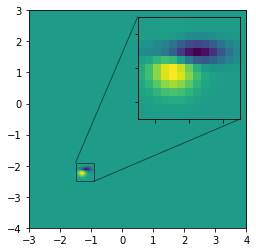

In [55]:
from matplotlib import cbook
import matplotlib.pyplot as plt
import numpy as np


def get_demo_image():
    z = cbook.get_sample_data("axes_grid/bivariate_normal.npy", np_load=True)
    # z is a numpy array of 15x15
    return z, (-3, 4, -4, 3)

fig, ax = plt.subplots(figsize=[5, 4])

# make data
Z, extent = get_demo_image()
Z2 = np.zeros((150, 150))
ny, nx = Z.shape
Z2[30:30+ny, 30:30+nx] = Z

ax.imshow(Z2, extent=extent, origin="lower")

# inset axes....
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.imshow(Z2, extent=extent, origin="lower")
# sub region of the original image
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()